# <a id='toc1_'></a>[TP1 - Clasificación de Textos en 20 Newsgroups](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [TP1 - Clasificación de Textos en 20 Newsgroups](#toc1_)    
  - [Introducción](#toc1_1_)    
    - [Consigna](#toc1_1_1_)    
    - [Integrantes del grupo](#toc1_1_2_)    
  - [Resolución](#toc1_2_)    
    - [EDA](#toc1_2_1_)    
      - [Balance de clases](#toc1_2_1_1_)    
      - [Preprocessing de la Data](#toc1_2_1_2_)    
    - [Archivos](#toc1_2_2_)    
    - [Gráficos (EDA)](#toc1_2_3_)    
    - [Pipeline](#toc1_2_4_)    
    - [Results](#toc1_2_5_)    
      - [Train Scores](#toc1_2_5_1_)    
      - [Test Scores](#toc1_2_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introducción](#toc0_)

### <a id='toc1_1_1_'></a>[Consigna](#toc0_)

Se trabajará con los datos de 20 Newsgroups.

Se pide:

* Realizar un EDA (análisis exploratorio de datos) del dataset, entre otros: frecuencia de palabras, distribución de clases, longitud de los documentos.
* Entrenar modelos de clasificación del tipo Naïve Bayes Multinomial y Regresión Logística. Realizar para ellos una búsqueda de hiperparámetros optimizando la métrica del desempeño de este problema. Separar adecuadamente los datos de validación de los de entrenamiento. Reportar métricas de desempeño en todos los casos.
* Para el mejor de los modelos encontrados de cada tipo (Naïve Bayes y Regresión logística), reportar su métrica de desempeño en el conjunto de datos de test.

### <a id='toc1_1_2_'></a>[Integrantes del grupo](#toc0_)

* CILFONE ARGIBAY, Juan Pablo
  * 62074
  * [jcilfoneargibay@itba.edu.ar](mailto:jcilfoneargibay@itba.edu.ar)
* HEIR, Alejandro Nahuel
  * 62496
  * [aheir@itba.edu.ar](mailto:aheir@itba.edu.ar)


*22.67 - Redes Neuronales*

*ITBA - Ingeniería Electrónica - Orientación Procesamiento de Señales - 4to año 2do cuatrimestre*

*Abril - Mayo 2024*

## <a id='toc1_2_'></a>[Resolución](#toc0_)

In [1]:
# Módulos para manipulación de datos y visualización
import numpy as np  # Para operaciones numéricas eficientes
import matplotlib.pyplot as plt  # Para graficar

# Módulos para procesamiento de lenguaje natural
from sklearn.datasets import fetch_20newsgroups  # Para obtener el dataset de twenty newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer  # Para vectorización de texto
from nltk.tokenize import word_tokenize  # Para tokenización de palabras
from nltk.stem import PorterStemmer, WordNetLemmatizer  # Para stemming y lematización
from nltk.corpus import stopwords  # Para obtener stopwords

# Módulos para modelos de machine learning
from sklearn.naive_bayes import MultinomialNB  # Para clasificador Naive Bayes multinomial
from sklearn.linear_model import LogisticRegression  # Para modelo de regresión logística
from sklearn.model_selection import GridSearchCV  # Para búsqueda de hiperparámetros
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Para evaluación de modelos
from sklearn.pipeline import Pipeline  # Para crear un pipeline de procesamiento

# Otros módulos
from tqdm import tqdm  # Para mostrar barras de progreso en bucles
from time import time  # Para medir tiempos de ejecución
import pickle  # Para guardar y cargar objetos Python

In [2]:
# Fetch de los data sets de train y test
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset="test", shuffle=True, remove=("headers", "footers", "quotes"))


### <a id='toc1_2_1_'></a>[EDA](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Balance de clases](#toc0_)

In [13]:
class_balance = np.zeros(len(twenty_train["target_names"]))

for i in range(len(twenty_train["target"])):
  class_balance[twenty_train["target"][i]] += 1

class_balance_probs = class_balance / len(twenty_train["target"])

In [8]:
num_classes = len(np.unique(twenty_train.target))
print(f"Número de clases: {num_classes}\n")

total_corpus_size = np.sum(class_balance)
print(f"Tamaño total del corpus (textos): {total_corpus_size}\n")

for i, class_name in enumerate(twenty_train.target_names):
  print(f"Clase '{class_name}': {class_balance[i]} textos")

Número de clases: 20

Tamaño total del corpus (textos): 11314.0

Clase 'alt.atheism': 480.0 textos
Clase 'comp.graphics': 584.0 textos
Clase 'comp.os.ms-windows.misc': 591.0 textos
Clase 'comp.sys.ibm.pc.hardware': 590.0 textos
Clase 'comp.sys.mac.hardware': 578.0 textos
Clase 'comp.windows.x': 593.0 textos
Clase 'misc.forsale': 585.0 textos
Clase 'rec.autos': 594.0 textos
Clase 'rec.motorcycles': 598.0 textos
Clase 'rec.sport.baseball': 597.0 textos
Clase 'rec.sport.hockey': 600.0 textos
Clase 'sci.crypt': 595.0 textos
Clase 'sci.electronics': 591.0 textos
Clase 'sci.med': 594.0 textos
Clase 'sci.space': 593.0 textos
Clase 'soc.religion.christian': 599.0 textos
Clase 'talk.politics.guns': 546.0 textos
Clase 'talk.politics.mideast': 564.0 textos
Clase 'talk.politics.misc': 465.0 textos
Clase 'talk.religion.misc': 377.0 textos


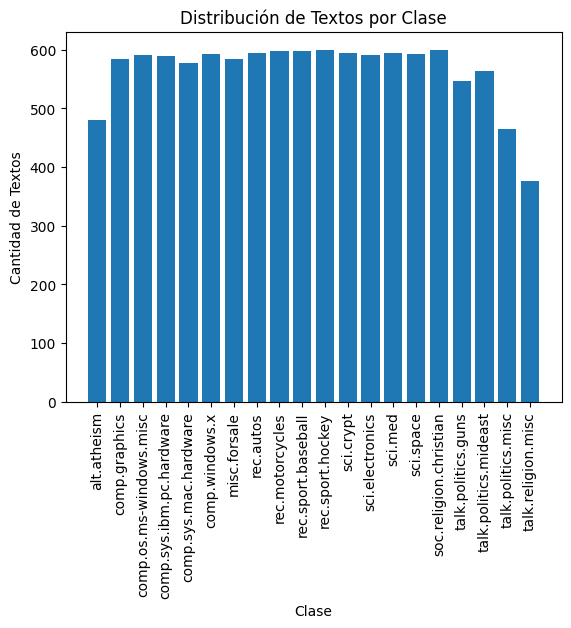

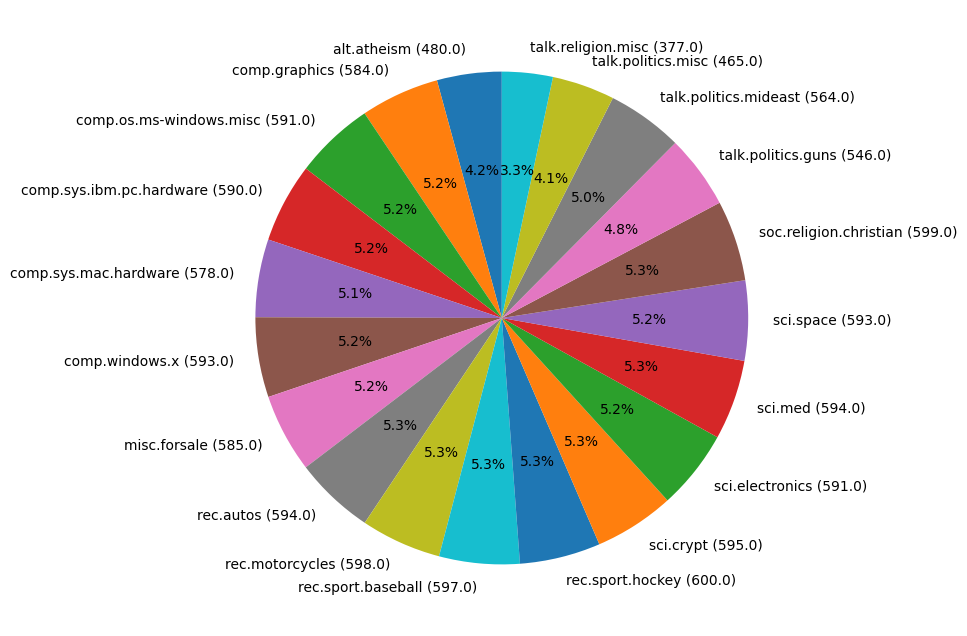

In [14]:
plt.bar(range(len(class_balance)), class_balance)
plt.xlabel('Clase')
plt.ylabel('Cantidad de Textos')
plt.title('Distribución de Textos por Clase')
plt.xticks(range(len(class_balance)), twenty_train.target_names, rotation=90)
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(class_balance_probs, labels=["{0} ({1})".format(twenty_train["target_names"][i], class_balance[i]) for i in range(len(twenty_train["target_names"]))], autopct="%1.1f%%", startangle=90)
plt.show()

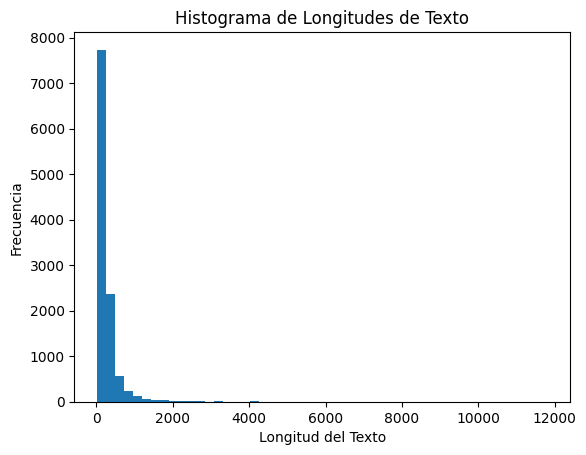

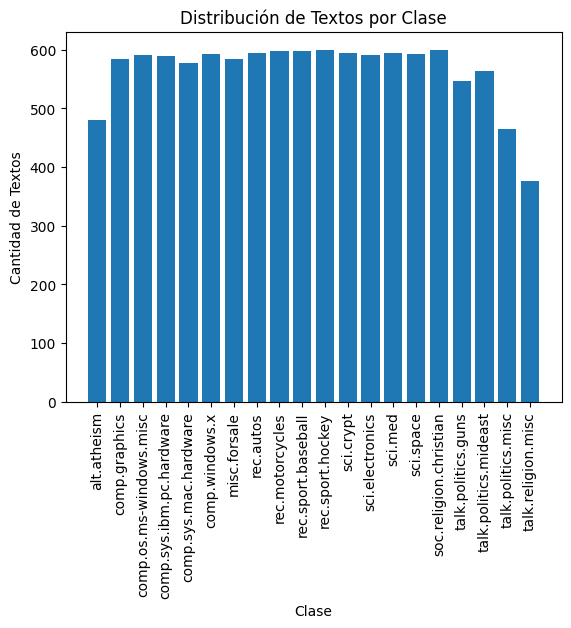

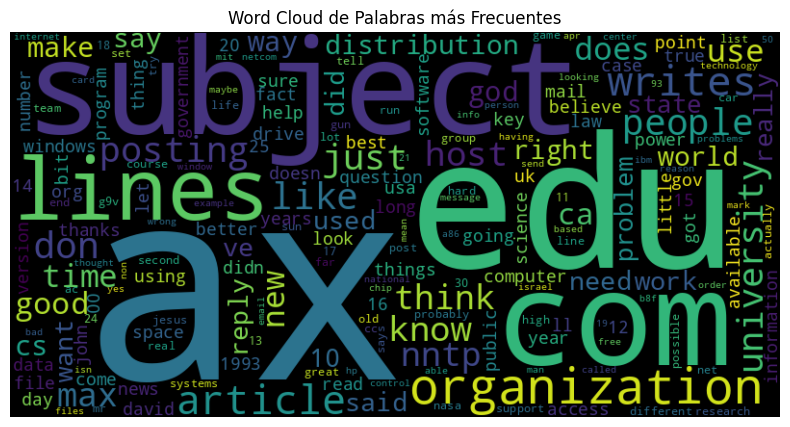

In [10]:
from wordcloud import WordCloud

# Cargar el dataset
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

# Histograma de Longitudes de Texto
text_lengths = [len(text.split()) for text in twenty_train.data]
plt.hist(text_lengths, bins=50)
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.title('Histograma de Longitudes de Texto')
plt.show()

# Gráfico de Barras de Distribución de Clases
class_balance = np.bincount(twenty_train.target)
plt.bar(range(len(class_balance)), class_balance)
plt.xlabel('Clase')
plt.ylabel('Cantidad de Textos')
plt.title('Distribución de Textos por Clase')
plt.xticks(range(len(class_balance)), twenty_train.target_names, rotation=90)
plt.show()

# Word Cloud de Palabras más Frecuentes
vectorizer = CountVectorizer(stop_words="english")
X_train = vectorizer.fit_transform(twenty_train.data)
word_counts = np.sum(X_train.toarray(), axis=0)
word_freq = {word: count for word, count in zip(vectorizer.get_feature_names_out(), word_counts)}
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Palabras más Frecuentes')
plt.show()

In [15]:


# **Longitudes de los textos**
text_lengths = [len(text.split()) for text in twenty_train.data]
print(f"\nLongitud mínima de texto: {min(text_lengths)}")
print(f"Longitud máxima de texto: {max(text_lengths)}")
print(f"Longitud promedio de texto: {np.mean(text_lengths)}")
print(f"Longitud mediana de texto: {np.median(text_lengths)}\n")

# **Estadísticas de palabras**
vectorizer = CountVectorizer(stop_words="english")
X_train = vectorizer.fit_transform(twenty_train.data)

unique_words_count = len(vectorizer.vocabulary_)
print(f"Número de palabras únicas: {unique_words_count}\n")

word_counts = np.sum(X_train.toarray(), axis=0)

most_frequent_words = np.argsort(word_counts)[::-1][:10]
for i in most_frequent_words:
  print(f"Palabra más frecuente: '{vectorizer.get_feature_names_out()[i]}', frecuencia: {word_counts[i]}")

least_frequent_words = np.argsort(word_counts)[:10]
for i in least_frequent_words:
  print(f"Palabra menos frecuente: '{vectorizer.get_feature_names_out()[i]}', frecuencia: {word_counts[i]}")



Longitud mínima de texto: 14
Longitud máxima de texto: 11821
Longitud promedio de texto: 287.4701255082199
Longitud mediana de texto: 176.0

Número de palabras únicas: 129796

Palabra más frecuente: 'ax', frecuencia: 62406
Palabra más frecuente: 'edu', frecuencia: 21321
Palabra más frecuente: 'subject', frecuencia: 12264
Palabra más frecuente: 'com', frecuencia: 12133
Palabra más frecuente: 'lines', frecuencia: 11835
Palabra más frecuente: 'organization', frecuencia: 11233
Palabra más frecuente: 'writes', frecuencia: 7844
Palabra más frecuente: 'article', frecuencia: 7438
Palabra más frecuente: 'people', frecuencia: 5975
Palabra más frecuente: 'don', frecuencia: 5953
Palabra menos frecuente: 'svf8385beit2', frecuencia: 1
Palabra menos frecuente: 'stultz', frecuencia: 1
Palabra menos frecuente: 'stultification', frecuencia: 1
Palabra menos frecuente: 'stuffy', frecuencia: 1
Palabra menos frecuente: 'dali', frecuencia: 1
Palabra menos frecuente: 'liantz', frecuencia: 1
Palabra menos fre

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# **Plot de las longitudes de los textos**
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=50)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Distribution of Text Lengths")
plt.show()

# **Plot de las palabras más frecuentes**
most_frequent_words = np.argsort(word_counts)[::-1][:10]
most_frequent_words_names = [vectorizer.get_feature_names_out()[i] for i in most_frequent_words]
most_frequent_words_counts = word_counts[most_frequent_words]

plt.figure(figsize=(8, 6))
plt.bar(most_frequent_words_names, most_frequent_words_counts)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Most Frequent Words")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, log=True)
plt.xlabel("Word Frequency")
plt.ylabel("Number of Words")
plt.title("Distribution of Word Frequencies")
plt.show()


#### <a id='toc1_2_1_2_'></a>[Preprocessing de la Data](#toc0_)

In [ ]:
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
def preprocess_article(article):
    tok = word_tokenize(article)
    lem = [lemmatizer.lemmatize(x, pos='v') for x in tok]
    stop = [x for x in lem if x not in stopwords.words('english')]
    stem = [stemmer.stem(x) for x in stop]
    alpha = [x for x in stem if x.isalpha()]
    return " ".join(alpha)

Filtrado del Train Dataset

In [ ]:
train_filt=list()
for i in tqdm(range(len(twenty_train.data))):
    art = twenty_train.data[i]
    filtered_article = preprocess_article(art)
    train_filt.append(filtered_article)

Filtrado del Test Dataset

In [ ]:
test_filt=list()
for i in tqdm(range(len(twenty_test.data))):
    art = twenty_test.data[i]
    filtered_article = preprocess_article(art)
    test_filt.append(filtered_article)

### <a id='toc1_2_2_'></a>[Archivos](#toc0_)

In [ ]:
import pickle

In [ ]:
#Salvado del procesamiento a disco:
# CUIDADO: AL CORRER SE BORRA/SOBREESCRIBE EL ARCHIVO 'art_filt.txt'
with open('art_filt_train.txt', 'wb') as fp:
    pickle.dump(train_filt, fp)

In [ ]:
with open('art_filt_test.txt', 'wb') as fp:
    pickle.dump(test_filt, fp)

### <a id='toc1_2_3_'></a>[Gráficos (EDA)](#toc0_)

In [ ]:
import pickle
with open ('art_filt_train.txt', 'rb') as fp:
  train_data = pickle.load(fp)

In [ ]:
with open ('art_filt_test.txt', 'rb') as fp:
  test_data = pickle.load(fp)

In [ ]:
# **Longitudes de los textos en el nuevo dataset**
text_lengths = [len(text.split()) for text in train_data]
print(f"Minimum text length: {min(text_lengths)}")
print(f"Maximum text length: {max(text_lengths)}")
print(f"Average text length: {np.mean(text_lengths)}")
print(f"Median text length: {np.median(text_lengths)}\n")

# **Estadísticas de palabras**
vectorizer = CountVectorizer(stop_words="english")
X_train = vectorizer.fit_transform(train_data)

unique_words_count = len(vectorizer.vocabulary_)
print(f"Number of unique words: {unique_words_count}\n")

word_counts = np.sum(X_train.toarray(), axis=0)

most_frequent_words = np.argsort(word_counts)[::-1][:20]
for i in most_frequent_words:
  print(f"Most frequent word: '{vectorizer.get_feature_names_out()[i]}', count: {word_counts[i]}")

least_frequent_words = np.argsort(word_counts)[:10]
for i in least_frequent_words:
  print(f"Least frequent word: '{vectorizer.get_feature_names_out()[i]}', count: {word_counts[i]}")

In [ ]:
# **Gráfico de distribución de longitudes de textos**
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=30)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Distribution of Text Lengths in the New Dataset")
plt.show()

# **Gráfico de las palabras más frecuentes**
plt.figure(figsize=(8, 6))
plt.bar(vectorizer.get_feature_names_out()[most_frequent_words], word_counts[most_frequent_words])
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in the New Dataset")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, log=True)
plt.xlabel("Word Frequency")
plt.ylabel("Number of Words")
plt.title("Distribution of Word Frequencies")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Define the range of max_df values
max_df_values = np.arange(0.01, 0.06,0.01)

# Initialize a list to store vocabulary sizes for each max_df value
vocab_sizes_list = []

# Iterate over max_df values
for max_df in max_df_values:
    vocab_sizes = []
    for min_df in range(8, 15):
        vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1, 2))
        X = vectorizer.fit_transform(train_data)
        vocab_sizes.append(len(vectorizer.vocabulary_))
    vocab_sizes_list.append(vocab_sizes)


In [ ]:
# Plot the vocabulary size vs min_df for each max_df value
plt.figure(figsize=(10, 6))
for i, max_df in enumerate(max_df_values):
    plt.plot(range(8, 15), vocab_sizes_list[i], label=f'max_df={max_df}')

plt.xlabel("min_df")
plt.ylabel("Vocabulary size")
plt.title("Vocabulary Size vs Min_df for Different Max_df Values")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
vocab_sizes = []
for max_df in np.arange(9/11314, 0.2, 0.05):
  vectorizer = CountVectorizer(max_df=max_df,min_df=8, ngram_range=(1, 2))
  X = vectorizer.fit_transform(train_data)
  vocab_sizes.append(vectorizer.vocabulary_.__len__())

In [ ]:
# Plot the vocabulary size vs max_df
plt.figure(figsize=(8, 6))
plt.plot(np.arange(9/11314,0.2,0.05), vocab_sizes)
plt.xlabel("max_df")
plt.ylabel("Vocabulary size")
plt.title("Vocabulary Size vs Max_df")
plt.show()

### <a id='toc1_2_4_'></a>[Pipeline](#toc0_)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from time import time
import numpy as np

In [ ]:

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameter_grid = {
    "vect__max_df": np.linspace(0.02,.1,5),
    "vect__min_df": (8,10,12),
    #"tfidf__use_idf": (True, False),
    "vect__ngram_range": ((1, 2),),  # unigrams or bigrams
    "clf__alpha": np.logspace(-6,-2,5)
}

if __name__ == "__main__":

      grid_search = GridSearchCV(pipeline, parameter_grid, n_jobs=-1, verbose=10,cv=2)

      print("Performing grid search...")
      print("pipeline:", [name for name, _ in pipeline.steps])
      print("parameters:")
      print(parameter_grid)
      t0 = time()
      grid_search.fit(train_data,twenty_train['target'])
      print("done in %0.3fs" % (time() - t0))
      print()

      print("Best score: %0.3f" % grid_search.best_score_)
      print("Best parameters set:")
      best_parameters = grid_search.best_estimator_.get_params()
      for param_name in sorted(parameter_grid.keys()):
          print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
with open('grid.txt', 'wb') as fp:
    pickle.dump(grid_search, fp)

### <a id='toc1_2_5_'></a>[Results](#toc0_)

In [ ]:
# @title **Grid Search**
with open('grid.txt', 'rb') as fp:
  grid_search_data = pickle.load(fp)

print("Grid scores:")
for mean, params in zip(grid_search_data.cv_results_['mean_test_score'],  grid_search_data.cv_results_['params']):
    print("%0.3f for %r" % (mean, params))

In [ ]:
# @title ### **Ejecución de un Naive Bayes "Normal" con parámetros óptimos**
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer(max_df=0.1,min_df=8, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data)
clf = MultinomialNB(alpha=0.01)
clf.fit(X_train, twenty_train["target"])


#### <a id='toc1_2_5_1_'></a>[Train Scores](#toc0_)

In [ ]:
import numpy as np
acc=sum(np.array(clf.predict(X_train))==np.array(twenty_train["target"]))/len(twenty_train["target"])*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(acc))

In [ ]:
acc=sum(np.array(grid_search_data.predict(train_data))==np.array(twenty_train["target"]))/len(twenty_train["target"])*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(acc))

In [ ]:
acc = np.mean(clf.predict(X_train) == twenty_train.target) * 100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(acc))

#### <a id='toc1_2_5_2_'></a>[Test Scores](#toc0_)

In [ ]:
porc=sum(np.array(grid_search_data.predict(test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))

In [ ]:
X_test = vectorizer.transform(test_data)
porc=sum(np.array(clf.predict(X_test))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("El porcentaje de artículos clasificados correctamente es: {}%".format(porc))